##  Report to clarify the model, (dependent variable) and independent variables

The corresponding notebook-file is 'Citybike-multiple-regression-aggregate-prediction-06-2017.ipynb'.

## The data and independent variables

In [27]:
# importing the libraries
%matplotlib inline
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
from scipy import interpolate 
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [28]:
sys.path.append(os.path.realpath('..'))
avail_data_file = "hourly-avg-2017-06-all-stations.csv"
weather_data_file = "fmi-weatherdata-Helsinki-Kaisaniemi-2017.csv"

##### Read and combine data
bikeData = pd.read_csv(avail_data_file, sep=',')
weatherData = pd.read_csv(weather_data_file, sep=",")
weatherData.rename(columns={'Vuosi': 'Year', 'Kk': 'Month', 'Pv': 'Day', 'Klo': 'Time', 'Aikavyöhyke': 'Timezone', 'Sateen intensiteetti (mm/h)': 'rainIntensity_mmh', 'Ilman lämpötila (degC)': 'temperature_c'}, inplace=True)  

# Filter only June 2017
weatherData = weatherData[weatherData.Month == 6]

# Reset dataframe indices to make combining work properly
bikeData = bikeData.reset_index(drop=True)
weatherData = weatherData.reset_index(drop=True)
bikeData['rainIntensity_mmh'] = weatherData['rainIntensity_mmh']
bikeData['temperature_c'] = weatherData['temperature_c']

# Assigning 'sumofhourlyavg' as the dependent variable y
# Assigning 'Sade' and 'Ilman_lampotila' as independent variables X (X is 2xn matrix here but it will still need the weekday-info and hour-columns to be complete)

X = bikeData.loc[:, ['rainIntensity_mmh','temperature_c']] # matrix of independent variables 'rainIntensity_mmh' and 'temperature_c'
y = bikeData[bikeData.columns[1]] # vector of 'sumofhourlyavg'

# Add hour to the matrix of independent variables
bikeData['hour'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)

# Add month to the matrix of independent variables
X['month'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)

# Add weekday to the matrix of independent variables. 0 is Monday, 6 is Sunday.
X['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

bikeData['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

### Independent variable 'rainIntensity_mmh':

If we plot the independent variable 'rainIntensity_mmh', we notice that when there's no rain, the availabilities vary between the stations, but if there's even small amount of raining, the availability-rate goes high. That consists basically from two factors: 1) people watch weather-forecasts and also observe the situation in a way that if there's been raining for the past hour, it is likely that there will be more rain (people plan whether they bike at all based on current/oncoming weather). 2) If it starts to rain while people are biking, it is also likely that they would just take the bike to the nearest stop and get bus/metro to avoid raining. If we would fit a straight line to this data, it woudn't provide much additional value to our model. We'll see that when I plot the line for the original 'rainIntensity_mmh' data with zero-values included.

Does splitting the prediction calculation based on recent rains provide a better prediction than a simple linear combination of temp, rain and hour estimates?

Axes(0.125,0.125;0.775x0.775)


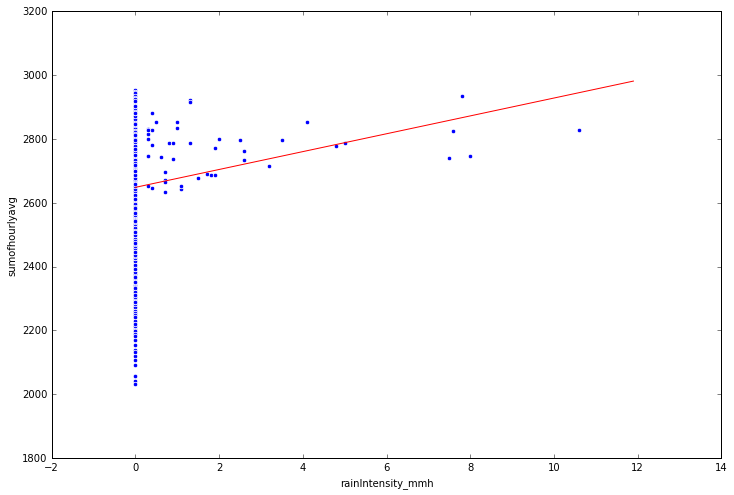

In [29]:
p_coeffsRain = np.polyfit(bikeData['rainIntensity_mmh'].values, bikeData['sumofhourlyavg'].values, 1)
#print(p_coeffsHours)

xx = np.arange(0,12,0.1)
yy = np.zeros(len(xx))
for i in range(len(xx)):
    yy[i] = np.polyval(p_coeffsRain, xx[i])

fig, ax = plt.subplots(1, 1, figsize=(12,8))
bx = sns.scatterplot(x='rainIntensity_mmh', y='sumofhourlyavg', data=bikeData)
plt.plot(xx, yy, 'r')
print(bx)

Fitting the line or curve to this kind of data would be problematic, so first of all we should remove the zero-raining values, because they create some skewness. Secondly, we should take into account the phenomena that people plan according to the weather forcasts. We could for example observe the history from the past 6 hours and calculate the moving average of those hours (https://en.wikipedia.org/wiki/Moving_average) 

### Applying moving average to transform the data (rainIntensity) with 8 hours 'history': calculated the average of past six hours. 

In [30]:
bikeData['rain_MA'] = weatherData['rainIntensity_mmh']
moving_average_window_size = 8

for i in range(len(weatherData['rainIntensity_mmh'])):
    avg_val = 0
    sum_count = 0
    for j in range(moving_average_window_size):
        if (i-j >= 0):
            avg_val += weatherData['rainIntensity_mmh'].values[i-j] # moving average
            sum_count += 1
    avg_val /= sum_count
    bikeData['rain_MA'].values[i] = avg_val

drop_indices = []
for i in range(len(bikeData['rain_MA'])):
    if (bikeData['rain_MA'][i] == 0):
        drop_indices = drop_indices+[i]

# zero values are dropped here so that only points with recent rain appear on the scatterplot
bikeData['rain_MA'] = bikeData['rain_MA'].drop(labels=drop_indices)

### N- degree polynomial fitting

In [31]:
rain_idx = np.isfinite(bikeData['rain_MA'].values) & np.isfinite(bikeData['sumofhourlyavg'].values)

p_coeffsTemp = np.polyfit(bikeData['temperature_c'].values, bikeData['sumofhourlyavg'].values, 4)
p_coeffsRain = np.polyfit(bikeData['rain_MA'].values[rain_idx], bikeData['sumofhourlyavg'].values[rain_idx], 2)
p_coeffsHours = np.polyfit(bikeData['hour'].values, bikeData['sumofhourlyavg'].values, 3)

xx_temp = np.arange(4,23,0.1)
yy_temp = np.zeros(len(xx_temp))
for i in range(len(xx_temp)):
    yy_temp[i] = np.polyval(p_coeffsTemp, xx_temp[i])

xx_rain = np.arange(0, 2.2, 0.02)
yy_rain = np.zeros(len(xx_rain))
for i in range(len(xx_rain)):
    yy_rain[i] = np.polyval(p_coeffsRain, xx_rain[i])

### Independent variable 'temperature_c':

If we plot the first variable 'temperature_c', we notice that it has ideal (ideal considering the model that we apply), swarm type of distribution when plotting against our dependent 'y' variable 'sumofhourlyavg':


Axes(0.125,0.125;0.775x0.775)


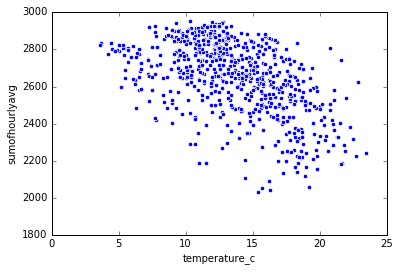

In [32]:
p_coeffsTemp2 = np.polyfit(bikeData['temperature_c'].values, bikeData['sumofhourlyavg'].values, 1)

yy2 = np.zeros(len(xx_temp))
for i in range(len(xx_temp)):
    yy2[i] = np.polyval(p_coeffsTemp2, xx_temp[i])

ax = sns.scatterplot(x='temperature_c', y='sumofhourlyavg', data=bikeData)
print(ax)

### Applying the polyfit for the 'temperature_c':

If we apply the 4th degree polynomial to our 'temperature_c' independent variable, we can see that it gives visually more flexible fitting curve than the basic 1st degree linear regression line. We notice that it predicts more availability, the colder it gets from +5 celcius and also more availability (according this data) when it gets over +23 - +24 celcius. If we go below 3 celcius or above 25 celcius, we would have to extrapolate instead of interpolating. Look at the end-tails below 5 celcius and 25 celcius: the inflection point is intuitively correct, if it's far too cold or hot then the bike-availability would trend upwards.

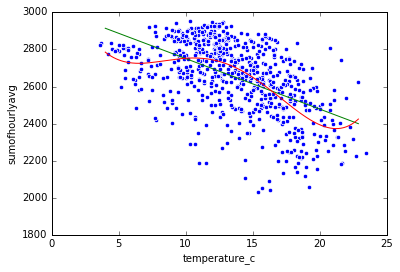

In [33]:
aax = sns.scatterplot(x='temperature_c', y='sumofhourlyavg', data=bikeData)
plt.plot(xx_temp,yy2, 'g')
plt.plot(xx_temp, yy_temp,'r')

### The problem with the independent variable 'weekday':

We can take a look of the 'weekday' variable by plotting it like the previous ones. However, it does not produce that kind of nice swarm-type of scatterplot (which usually implies that that type of data is suitable for linear/polynomial models). Instead, the values are discrete, with values 0 to 6 (monday to sunday).

As we can see from the scatterplot, weekday variable is at the end of the day a  categorical variable, so it cannot be applied to our model without modifying the model to be some kind of mixed model that combines polynomial model and logistic regression model. Also, we have to think what additional value this data would provide to our model and just by looking it with this plot, there's merely any difference between the availabilitys of most of the days: we can see slightly more useage on wednesday and friday, but because it's categorical, it can be applied to logistic models, rather than linear/polynomial. 

We are not applying neural networks or mathematical optimization of the coefficients applied to the n-degree polynomial predictors, so adding the variance explained by the weekday provides more complications than benefits, since the variance it can explain is only +/-30 bikes. 

Axes(0.125,0.125;0.775x0.775)


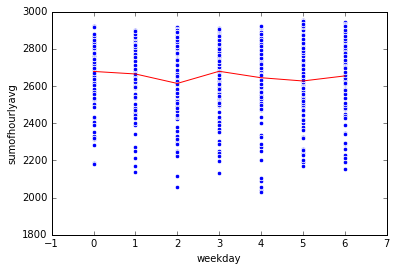

In [34]:
p_coeffsWeekday = np.polyfit(X['weekday'].values, bikeData['sumofhourlyavg'].values, 6)

xx = np.arange(0,7,1)
yy = np.zeros(len(xx))
for i in range(len(xx)):
    yy[i] = np.polyval(p_coeffsWeekday, xx[i])

cx = sns.scatterplot(x='weekday', y='sumofhourlyavg', data=bikeData)
plt.plot(xx, yy, 'r')
print(cx)